In this notebook, we will show you the differents steps to train step by step dly your model in this competition.

# Images Extractions

Imports

In [1]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from transformers import ResNetModel, TrainingArguments, Trainer, ResNetConfig, ResNetForImageClassification
import torch
import torchvision.transforms as transforms
import evaluate
from datasets import Dataset
import altair as alt
warnings.filterwarnings('ignore')

/workspaces/Africa-Biomass-Challenge/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

In [3]:
from sklearn import set_config
set_config(display='diagram')

Uncomment to download data

In [4]:
# !wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_train.h5
# !wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_val.h5
# !wget -q https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_test.h5

In [5]:
trainset = h5py.File("09072022_1154_train.h5", "r")
validateset = h5py.File("09072022_1154_val.h5", "r")
testset = h5py.File("09072022_1154_test.h5", "r")

Data Exploration

In [6]:
# attributes of trainset
trainset.keys()

<KeysViewHDF5 ['agbd', 'cloud', 'images', 'lat', 'lon', 'scl']>

**Total Baseline RMSE in test data reported in Results**

In [26]:
f"Total baseline RMSE in test dataset: {mse(testset['agbd'][()], testset['agbd'][()].mean() * np.ones(testset['agbd'][()].shape[0]), squared=False): .2f}."

'Total baseline RMSE in test dataset:  65.18.'

(0.0, 400.0)

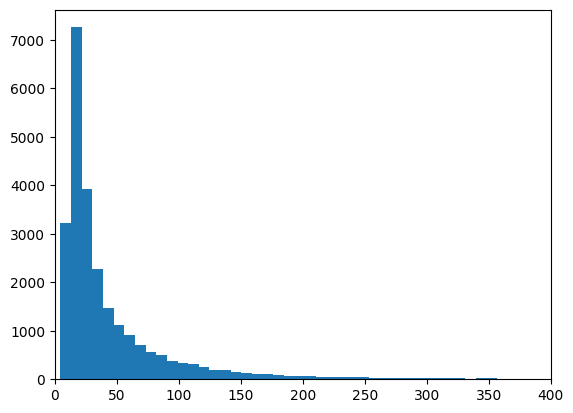

In [9]:
plt.hist(np.array(trainset['agbd']), bins = 100)
plt.xlim(0, 400)

Text(0.5, 1.0, 'Histogram of pixel values for all 12 bands')

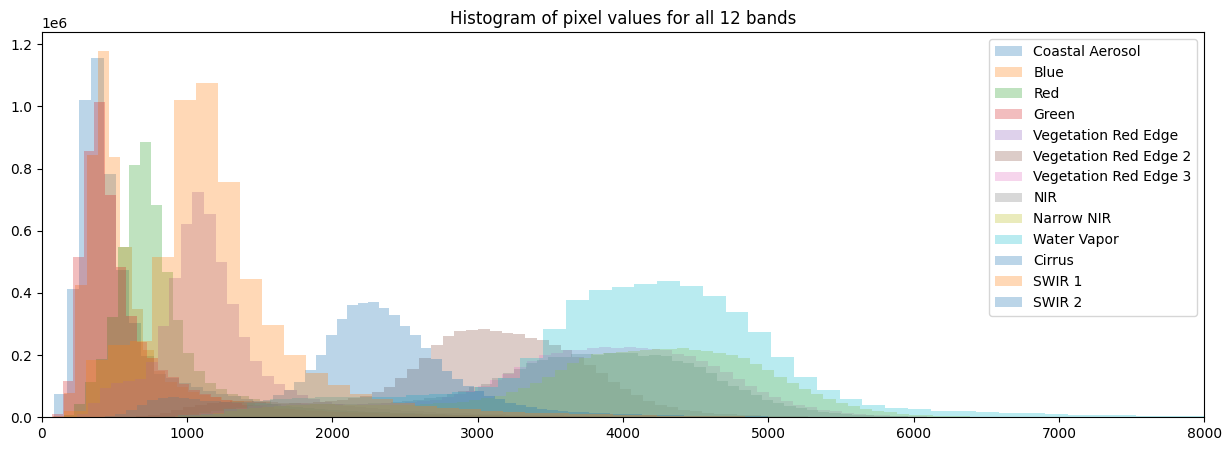

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

for i in range(0, 12):
    axs.hist(np.array(trainset['images'])[:, :, :, i].reshape(-1), bins = 100, alpha = 0.3, label = i)

axs.legend(['Coastal Aerosol', 'Blue', 'Red', 'Green', 'Vegetation Red Edge', 'Vegetation Red Edge 2', 'Vegetation Red Edge 3', 'NIR', 'Narrow NIR', 'Water Vapor', 'Cirrus', 'SWIR 1', 'SWIR 2'])
axs.set_xlim(0, 8_000)
axs.set_title('Histogram of pixel values for all 12 bands')

Image Exploration

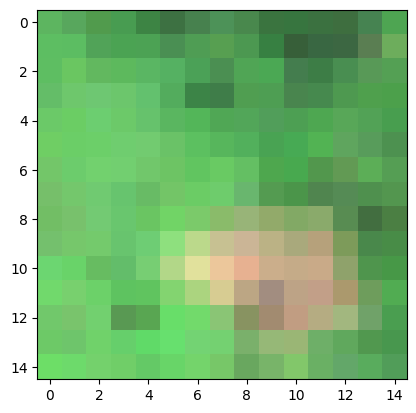

In [10]:
plt.imshow(np.array(trainset['images'])[0, :, :, [3, 2, 1]].T / 1_000)

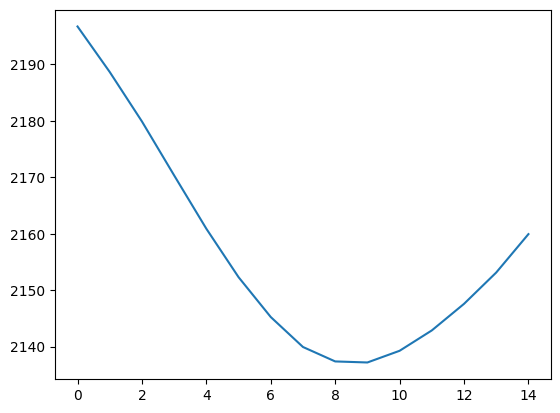

In [11]:
plt.plot(np.array(trainset['images']).mean(axis = 3).mean(axis = 0)[6])

In [12]:
trainset['images'].shape

(25036, 15, 15, 12)

Image Location Exploration

In [15]:
alt.Chart(pd.DataFrame({'latitude': np.array(trainset['lat'])[[2, 3, 4, 5, 6, 7, 8, 9]].reshape(-1), 'longitude': np.array(trainset['lon'])[[2, 3, 4, 5, 6, 7, 8, 9]].reshape(-1), 'red': np.array(trainset['images'])[[2, 3, 4, 5, 6, 7, 8, 9], :, :, 2].reshape(-1) / 700})).mark_point().encode(x = alt.X('longitude:Q', scale = alt.Scale(zero = False)), y = alt.Y('latitude:Q', scale = alt.Scale(zero = False)), color = 'red:Q')

alt.Chart(...)

In [16]:
alt.Chart(pd.DataFrame({'latitude': np.array(trainset['lat'])[[2, 3, 4, 5, 6, 7, 8, 9, 10]].reshape(-1), 'longitude': np.array(trainset['lon'])[[2, 3, 4, 5, 6, 7, 8, 9, 10]].reshape(-1), 'red': np.array(trainset['images'])[[2, 3, 4, 5, 6, 7, 8, 9, 10], :, :, 2].reshape(-1) / 700})).mark_point().encode(x = alt.X('longitude:Q', scale = alt.Scale(zero = False)), y = alt.Y('latitude:Q', scale = alt.Scale(zero = False)), color = 'red:Q')

alt.Chart(...)

## Explore datasets

In [7]:
# train
train_images = np.array(trainset['images'],dtype=np.float64)
train_images = train_images.transpose(0,3,1,2)
train_biomasses = np.array(trainset['agbd'],dtype=np.float64)

# validate
validate_images = np.array(validateset['images'],dtype=np.float64)
validate_images = validate_images.transpose(0,3,1,2)
validate_biomasses = np.array(validateset['agbd'],dtype=np.float64)

# test 
test_images = np.array(testset['images'],dtype=np.float32)
test_images = test_images.transpose(0,3,1,2)
test_biomasses = np.array(testset['agbd'],dtype=np.float32)

##  Some visulizations

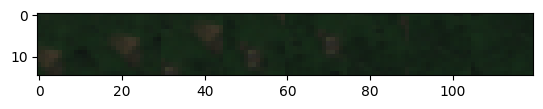

In [ ]:
plt.imshow(
    np.concatenate(
        (
            train_images[2, [3,2,1], :, :].T / 4095, 
            train_images[3, [3,2,1], :, :].T / 4095,
            train_images[4, [3,2,1], :, :].T / 4095,
            train_images[5, [3,2,1], :, :].T / 4095,
            train_images[6, [3,2,1], :, :].T / 4095,
            train_images[7, [3,2,1], :, :].T / 4095,
            train_images[8, [3,2,1], :, :].T / 4095,
            train_images[9, [3,2,1], :, :].T / 4095,
            )
            , axis=1))

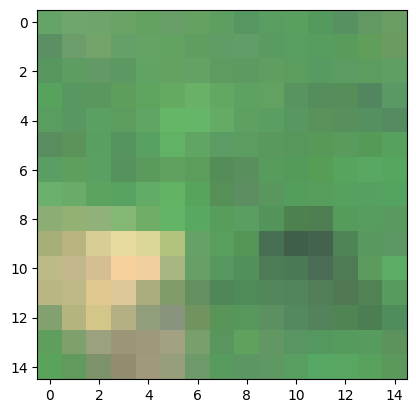

In [ ]:
plt.imshow(train_images[2, [3,2,1], :, :].T / 4095 * 4)

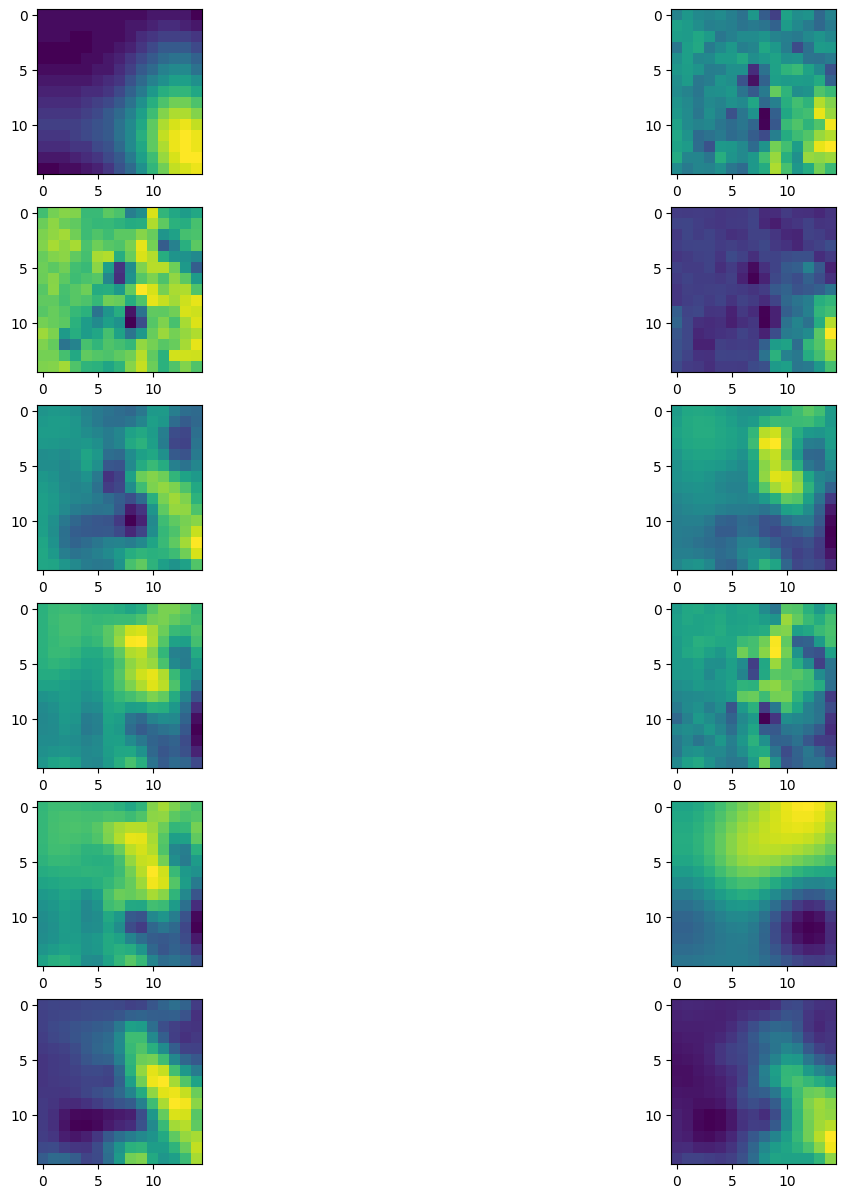

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(15, 15))
axs[0, 0].imshow(train_images[1,0,:,:])
axs[0, 1].imshow(train_images[1,1,:,:])
axs[1, 0].imshow(train_images[1,2,:,:])
axs[1, 1].imshow(train_images[1,3,:,:])
axs[2, 0].imshow(train_images[1,4,:,:])
axs[2, 1].imshow(train_images[1,5,:,:])
axs[3, 0].imshow(train_images[1,6,:,:])
axs[3, 1].imshow(train_images[1,7,:,:])
axs[4, 0].imshow(train_images[1,8,:,:])
axs[4, 1].imshow(train_images[1,9,:,:])
axs[5, 0].imshow(train_images[1,10,:,:])
axs[5, 1].imshow(train_images[1,11,:,:])


 **Below we explore the skewness of train dataset in each channel** (from Challenge starter code)

In [ ]:
band_skewness = []
band_skewness_after_sqrt = []
for c in range(12):
    #calculate skewness
    band_skewness.append(pd.Series(train_images[:,c].flatten()).skew())
    #calculate skewness after applying sqrt
    band_skewness_after_sqrt.append(pd.Series(np.sqrt(train_images[:,c].flatten())).skew())

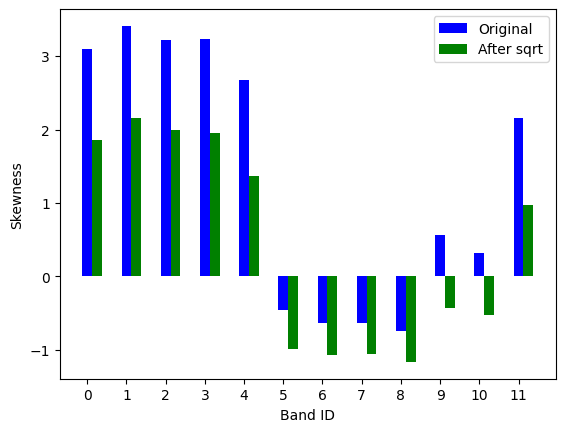

In [ ]:
# skweness
width = 0.25

rng = [i for i in range(0,12)]
rng2 = [i+width for i in range(0,12)]

plt.bar(rng, band_skewness, align='center', width = width, label='Original', color ='b')
plt.bar(rng2, band_skewness_after_sqrt, align='center', width = width, label='After sqrt', color ='g')
plt.gca().set_xticks(rng)
plt.legend()
plt.xlabel('Band ID')
plt.ylabel('Skewness')
plt.show()

# First Baseline With Sklearn (from Challenge Starter code)

## Modelisation

### Pipeline of training

In [8]:
# constante for standardization
MEAN = train_images.mean((0,2,3))
STD = train_images.std((0,2,3))

In [9]:
class CustomScaler(BaseEstimator, TransformerMixin):
  def __init__(self,mean,std):
    self.mean = mean
    self.std = std
  
  def fit(self, X, y=None):
    #self.mean = X.mean((0,2,3)) 
    #self.std = X.std((0,2,3))
    return self

  def transform(self, X, y=None):
    return (X-self.mean[None,:,None,None])/self.std[None,:,None,None] 

    
class FlattenTransformer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    return X.reshape((X.shape[0], -1))


pipe = Pipeline(steps=[("scaler", CustomScaler(MEAN,STD)),
                       ("flatten", FlattenTransformer()),
                       ("classifier", Lasso())
])

In [10]:
pipe.fit(train_images,train_biomasses)

Pipeline(steps=[('scaler',
                 CustomScaler(mean=array([ 644.62522678,  675.00465197,  887.51322647,  649.01398076,
       1230.65511708, 3005.58275568, 3717.91194245, 3626.2871387 ,
       3999.28166498, 4109.51322682, 2262.52644121, 1253.58153468]),
                              std=array([ 575.97684675,  570.30180631,  536.11125314,  550.22417005,
        557.76750885,  777.03590322,  935.15224447,  949.36012986,
        988.61001558, 1096.67397739,  671.68692054,  590.6012704 ]))),
                ('flatten', FlattenTransformer()), ('classifier', Lasso())])

In [11]:
# predict
pred_train = pipe.predict(train_images)

# train mse error
mse = mean_squared_error(train_biomasses, pred_train) 
mse
#rmse = np.sqrt(mse)

3023.555305378208

In [13]:
# predict
pred_validate = pipe.predict(validate_images)

#  validate mse error
mse = mean_squared_error(validate_biomasses, pred_validate) 
mse
#rmse = np.sqrt(mse)

3961.942859655493

## Nick, Heather, and Lorna's CNN Models Here:

#### Linear Regression Baseline Model (no normalization)

In [8]:
flattened_train_images = train_images.reshape(train_images.shape[0], -1)
train_values = trainset['agbd'][()]

flattened_validate_images = validate_images.reshape(validate_images.shape[0], -1)
validate_values = validateset['agbd'][()]

test_values = testset['agbd'][()]

In [11]:
from sklearn.linear_model import LinearRegression

baselineLR = LinearRegression()
baselineLR.fit(flattened_train_images, train_values)
print(f"R Squared: {baselineLR.score(flattened_validate_images, validate_values)}")

R Squared: 0.018846359229655607


In [36]:
from sklearn.metrics import mean_squared_error as mse

print(f"MSE: {mse(validate_values, baselineLR.predict(flattened_validate_images))}")

MSE: 4017.3378907032165


#### Linear Regression Baseline Model with L1 Regularization (no normalization)

In [67]:
from sklearn.linear_model import Lasso

baselineLasso = Lasso(alpha = 80.)
baselineLasso.fit(flattened_train_images, train_values)
print(f"R Squared: {baselineLasso.score(flattened_validate_images, validate_values)}")

R Squared: 0.0733426712787747


In [68]:
from sklearn.metrics import mean_squared_error as mse

print(f"MSE: {mse(validate_values, baselineLasso.predict(flattened_validate_images))}")

MSE: 3794.2025017068295


#### Random Forest Baseline Model (no normalization)

In [32]:
from sklearn.ensemble import RandomForestRegressor

baselineRF = RandomForestRegressor(n_estimators=10)
baselineRF.fit(flattened_train_images, train_values)
print(f"R Squared: {baselineRF.score(flattened_validate_images, validate_values)}")

KeyboardInterrupt: 

In [ ]:
print(f"MSE: {mse(validate_values, baselineRF.predict(flattened_validate_images))}")

MSE: 4057.8432610605823


#### Pre-Trained CNN with Linear Regression Model (no normalization, no image augmentation)

In [36]:
pretrained_CNN = ResNetModel.from_pretrained("microsoft/resnet-50") # Loading a pre-trained ResNet without the classifier

with torch.no_grad():
    outputs = pretrained_CNN(**{'pixel_values': torch.from_numpy(train_images[:, [3, 2, 1], :, :]).to(torch.float)}) # Getting the outputs of the ResNet without the classifier

train_hidden_states = outputs.last_hidden_state

with torch.no_grad():
    outputs = pretrained_CNN(**{'pixel_values': torch.from_numpy(validate_images[:, [3, 2, 1], :, :]).to(torch.float)}) # Getting the outputs of the ResNet without the classifier

validate_hidden_states = outputs.last_hidden_state

with torch.no_grad():
    outputs = pretrained_CNN(**{'pixel_values': torch.from_numpy(test_images[:, [3, 2, 1], :, :]).to(torch.float)}) # Getting the outputs of the ResNet without the classifier

test_hidden_states = outputs.last_hidden_state

Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.weight', 'classifier.1.bias']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Flattening Pre-trained Outputs

In [39]:
flattened_train_hidden = train_hidden_states.reshape(train_hidden_states.shape[0], -1)
flattened_validate_hidden = validate_hidden_states.reshape(validate_hidden_states.shape[0], -1)
flattened_test_hidden = test_hidden_states.reshape(test_hidden_states.shape[0], -1)

In [30]:
cNN_LR1 = LinearRegression()
cNN_LR1.fit(flattened_train_hidden, train_values)
print(f"R Squared: {cNN_LR1.score(flattened_validate_hidden, validate_values)}")

R Squared: -1.0395274970820263


In [31]:
print(f"MSE: {mse(validate_values, cNN_LR1.predict(flattened_validate_hidden))}")

MSE: 8350.8544921875


#### Pre-Trained CNN with Random Forest Model (no normalization, no image augmentation)

In [45]:
cNN_RF1 = RandomForestRegressor()
cNN_RF1.fit(flattened_train_hidden, train_values)
print(f"R Squared: {cNN_RF1.score(flattened_validate_hidden, validate_values)}")

R Squared: -0.03484502826613922


In [46]:
print(f"MSE: {mse(validate_values, cNN_RF1.predict(flattened_validate_hidden), squared = False)}")

MSE: 65.0936057733886


#### Pre-Trained CNN with MLP Regressor Model (no normalizaiton, no image augmentation)

In [41]:
from sklearn.neural_network import MLPRegressor

cNN_MLP = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter= 40, learning_rate = 'adaptive', early_stopping= True, validation_fraction= .15)
cNN_MLP.fit(flattened_train_hidden, train_values)
print(f"R Squared: {cNN_MLP.score(flattened_test_hidden, test_values)}")

R Squared: -0.0040021192159338526


In [42]:
print(f"MSE: {mse(test_values, cNN_MLP.predict(flattened_test_hidden), squared = False)}")

MSE: 65.30829620361328


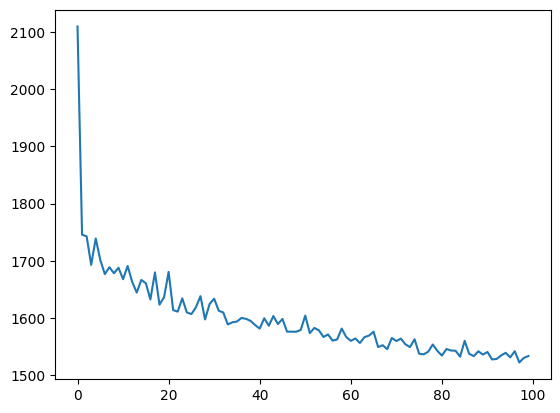

In [51]:
plt.plot(cNN_MLP.loss_curve_)

#### Pre-Trained ResNet with MLP Regressor Model (no normalizaiton, image resized)

Uncomment to run (takes very long, worse performance)

In [32]:
# resized_train_images = {'pixel_values': (transforms.Resize((224,224))(torch.from_numpy(train_images[:5000, [3, 2, 1], :, :]))).to(torch.float)}

# resized_validate_images = {'pixel_values': (transforms.Resize((224,224))(torch.from_numpy(validate_images[:1000, [3, 2, 1], :, :]))).to(torch.float)}

In [33]:
# with torch.no_grad():
#     outputs = pretrained_CNN(**resized_train_images) # Getting the outputs of the ResNet without the classifier

# resized_train_hidden = outputs.last_hidden_state

# with torch.no_grad():
#     outputs = pretrained_CNN(**resized_validate_images) # Getting the outputs of the ResNet without the classifier

# resized_validate_hidden = outputs.last_hidden_state

In [34]:
# flat_resized_train_hidden = resized_train_hidden.reshape(resized_train_hidden.shape[0], -1)
# flat_resized_validate_hidden = resized_validate_hidden.reshape(resized_validate_hidden.shape[0], -1)

In [47]:
# cNN_MLP2 = MLPRegressor(hidden_layer_sizes=(100,), max_iter= 100, learning_rate_init = .0001)
# cNN_MLP2.fit(flat_resized_train_hidden, train_values[:5000])
# print(f"R Squared: {cNN_MLP2.score(flat_resized_validate_hidden, validate_values[:1000])}")

R Squared: -3.757275889739626


In [48]:
# print(f"MSE: {mse(validate_values[:1000], cNN_MLP2.predict(flat_resized_validate_hidden[:1000]))}")

MSE: 13471.379389623817


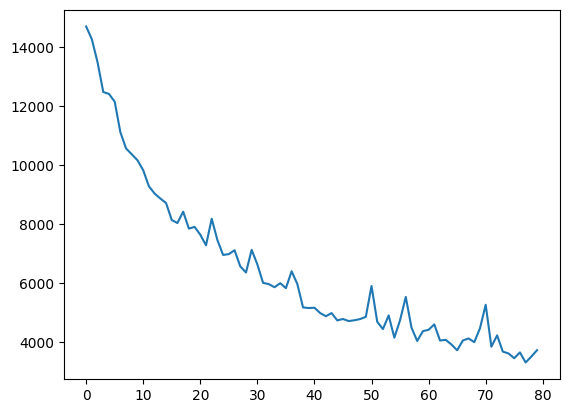

In [56]:
# plt.plot(cNN_MLP2.loss_curve_[20:])

#### Custom Configured ResNet (no normalization, no image augmentation)

In [9]:
allbands_train_dataset = Dataset.from_dict({'pixel_values': torch.from_numpy(train_images).to(torch.float), 'labels': train_values})

allbands_eval_dataset = Dataset.from_dict({'pixel_values': torch.from_numpy(validate_images).to(torch.float), 'labels':validate_values})

Uncomment to run (several models are commented out during hyperparameter tuning, only final model is uncommented)

In [50]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 12, hidden_sizes = [256], depths = [16], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [15]:
# custom_model = ResNetForImageClassification.from_pretrained("test_trainer/checkpoint-3500")

In [18]:
# training_args = TrainingArguments(output_dir="test_trainer", per_device_train_batch_size=2000,
#                                   per_device_eval_batch_size=2000, logging_strategy='epoch', 
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch', 
#                                   num_train_epochs=25.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=allbands_train_dataset,
#     eval_dataset=allbands_eval_dataset,
#     compute_metrics=compute_metrics,
# )


In [15]:
# trainer.train()

In [16]:
# trainer.train(resume_from_checkpoint = True)

Skipping the first batches: : 0it [00:03, ?it/s]


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=325, training_loss=1283.8534375, metrics={'train_runtime': 809.9801, 'train_samples_per_second': 772.735, 'train_steps_per_second': 0.401, 'total_flos': 1.18534225095e+16, 'train_loss': 1283.8534375, 'epoch': 25.0})

In [17]:
# data = pd.read_json('test_trainer/checkpoint-325/trainer_state.json')['log_history']

In [20]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [21]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [19]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 12, hidden_sizes = [256], depths = [32], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [20]:
# training_args = TrainingArguments(output_dir="test_trainer2", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch', 
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch', 
#                                   num_train_epochs=50.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=allbands_train_dataset,
#     eval_dataset=allbands_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [21]:
# trainer.train(resume_from_checkpoint = True)

Skipping the first batches: : 0it [00:01, ?it/s]


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [22]:
# data = pd.read_json('test_trainer2/checkpoint-858/trainer_state.json')['log_history']

In [23]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [24]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

Using all of the data (including cloud and location)

In [9]:
train_cloud = np.array(trainset['cloud'],dtype=np.float64)
train_cloud = train_cloud.transpose(0,3,1,2)

validate_cloud = np.array(validateset['cloud'],dtype=np.float64)
validate_cloud = validate_cloud.transpose(0,3,1,2)

test_cloud = np.array(testset['cloud'],dtype=np.float64)
test_cloud = test_cloud.transpose(0,3,1,2)

train_lat = np.array(trainset['lat'],dtype=np.float64)
train_lat = train_lat.transpose(0,3,1,2)

validate_lat = np.array(validateset['lat'],dtype=np.float64)
validate_lat = validate_lat.transpose(0,3,1,2)

test_lat = np.array(testset['lat'],dtype=np.float64)
test_lat = test_lat.transpose(0,3,1,2)

train_lon = np.array(trainset['lon'],dtype=np.float64)
train_lon = train_lon.transpose(0,3,1,2)

validate_lon = np.array(validateset['lon'],dtype=np.float64)
validate_lon = validate_lon.transpose(0,3,1,2)

test_lon = np.array(testset['lon'],dtype=np.float64)
test_lon = test_lon.transpose(0,3,1,2)

In [10]:
alldata_train_dataset = Dataset.from_dict({'pixel_values': torch.from_numpy(np.concatenate(
    (train_images, train_cloud, train_lat, train_lon), axis=1)).to(torch.float), 'labels': train_values})

alldata_eval_dataset = Dataset.from_dict({'pixel_values': torch.from_numpy(np.concatenate(
    (validate_images, validate_cloud, validate_lat, validate_lon), axis=1)).to(torch.float), 'labels': validate_values})

alldata_test_dataset = Dataset.from_dict({'pixel_values': torch.from_numpy(np.concatenate(
    (test_images, test_cloud, test_lat, test_lon), axis=1)).to(torch.float), 'labels': test_values})


In [19]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [256], depths = [50], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [22]:
# training_args = TrainingArguments(output_dir="allData_trainer", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch', 
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch', 
#                                   num_train_epochs=50.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [23]:
# trainer.train()

In [45]:
# data = pd.read_json('allData_trainer/checkpoint-858/trainer_state.json')['log_history']

In [46]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [47]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [20]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [256], depths = [16], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [22]:
# training_args = TrainingArguments(output_dir="allData_trainer2", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch', 
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch', 
#                                   num_train_epochs=200.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [23]:
# trainer.train(resume_from_checkpoint = True)

Skipping the first batches: : 0it [00:02, ?it/s]


Epoch,Training Loss,Validation Loss


In [4]:
# data = pd.read_json('allData_trainer2/checkpoint-2080/trainer_state.json')['log_history']

In [5]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [6]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

/workspaces/Africa-Biomass-Challenge/.conda/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [27]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [256], depths = [32], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [29]:
# training_args = TrainingArguments(output_dir="allData_trainer3", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch', 
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch', 
#                                   num_train_epochs=50.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [30]:
# trainer.train(resume_from_checkpoint = True)

Skipping the first batches: : 0it [00:02, ?it/s]


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [31]:
# data = pd.read_json('allData_trainer3/checkpoint-728/trainer_state.json')['log_history']

In [32]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [33]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [78]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [256, 25], depths = [32, 3], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [79]:
# training_args = TrainingArguments(output_dir="allData_trainer4", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch', 
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch', 
#                                   num_train_epochs=50.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [80]:
# trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [81]:
# data = pd.read_json('allData_trainer4/checkpoint-260/trainer_state.json')['log_history']

In [82]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [83]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [13]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [256, 25], depths = [32, 3], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [98]:
# training_args = TrainingArguments(output_dir="allData_trainer4-1", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch', 
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch', 
#                                   num_train_epochs=50.,
#                                   learning_rate=.01)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [99]:
# trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [103]:
# data = pd.read_json('allData_trainer4-1/checkpoint-312/trainer_state.json')['log_history']

In [104]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [105]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [ ]:
# Initializing a ResNet resnet-32 style configuration (with three added layers included, downsized for regularization)
configuration = ResNetConfig(num_channels = 15, hidden_sizes = [256, 25], depths = [32, 3], num_labels = 1)

# Initializing a model (with random weights) from the resnet-50 style configuration
custom_model = ResNetForImageClassification(configuration)

# Accessing the model configuration
configuration = custom_model.config

In [14]:
training_args = TrainingArguments(output_dir="allData_trainer4-2", per_device_train_batch_size=1000,
                                  per_device_eval_batch_size=1000, logging_strategy='epoch', 
                                  save_strategy = 'epoch',
                                  evaluation_strategy = 'epoch', 
                                  num_train_epochs=10.,
                                  learning_rate=.001)

mse_metric = evaluate.load("mse")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return mse_metric.compute(predictions=predictions, references=labels)


trainer = Trainer(
    model=custom_model,
    args=training_args,
    train_dataset=alldata_train_dataset,
    eval_dataset=alldata_eval_dataset,
    compute_metrics=compute_metrics,
)

In [16]:
trainer.train()

In [17]:
data = pd.read_json('allData_trainer4-2/checkpoint-1560/trainer_state.json')['log_history']

In [18]:
df = pd.DataFrame()
for each in data:
    for keys in each:
        if keys != 'epoch':
            df.loc[each['epoch'], keys] = each[keys]

In [19]:
alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [84]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [289, 225, 144, 100, 64, 25], depths = [3, 3, 3, 3, 3, 3], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [85]:
# training_args = TrainingArguments(output_dir="allData_trainer5", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch', 
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch', 
#                                   num_train_epochs=50.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [86]:
# trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

**Testing Trained ResNet-32 Model**

In [18]:
resnet_32 = ResNetForImageClassification.from_pretrained("allData_trainer4-2/checkpoint-78") # Loading a pre-trained ResNet without the classifier

In [67]:
np.array(alldata_eval_dataset['pixel_values']).shape

(5174, 15, 15, 15)

In [74]:
with torch.no_grad():
    outputs = resnet_32(torch.tensor(alldata_test_dataset['pixel_values'])) # Getting the outputs of the ResNet without the classifier

outputs.logits

tensor([[36.2939],
        [95.6092],
        [37.3444],
        ...,
        [40.4360],
        [33.0045],
        [50.9275]])

In [78]:
mse(np.array(alldata_test_dataset['labels']), outputs.logits.numpy().reshape(-1), squared = False)

60.271914774627874

In [21]:
r2_score(np.array(alldata_test_dataset['labels']), outputs.logits.numpy().reshape(-1))

-0.24529973661205218

**Create Masks of Averages for Each Band**

In [11]:
bandMeans = []
alldata_test_array = np.array(alldata_test_dataset['pixel_values'])
for eachBand in range(alldata_test_array.shape[1]):
    bandMeans.append(alldata_test_array[:, eachBand, :, :].mean())

**RMSE and R-Squared for Masked Channels**

In [24]:
for eachChannel in range(masked_array.shape[1]):

    masked_array = alldata_test_array.copy()
    
    masked_array[:, eachChannel, :, :] = bandMeans[eachChannel]

    with torch.no_grad():
        outputs = resnet_32(torch.from_numpy(masked_array).to(torch.float32)) # Getting the outputs of the ResNet without the classifier

    print(f"Channel {eachChannel} MSE: {mse(np.array(alldata_test_dataset['labels']), outputs.logits.numpy().reshape(-1), squared = False): .2f}")

    print(f"Channel {eachChannel} R-Squared: {r2_score(np.array(alldata_test_dataset['labels']), outputs.logits.numpy().reshape(-1)) * 100: .2f}%")

Channel 0 MSE:  72.73
Channel 0 R-Squared: -24.53%
Channel 1 MSE:  71.92
Channel 1 R-Squared: -21.74%
Channel 2 MSE:  63.36
Channel 2 R-Squared:  5.49%
Channel 3 MSE:  60.53
Channel 3 R-Squared:  13.76%
Channel 4 MSE:  65.94
Channel 4 R-Squared: -2.35%
Channel 5 MSE:  82.54
Channel 5 R-Squared: -60.36%
Channel 6 MSE:  63.29
Channel 6 R-Squared:  5.72%
Channel 7 MSE:  61.83
Channel 7 R-Squared:  10.00%
Channel 8 MSE:  88.26
Channel 8 R-Squared: -83.37%
Channel 9 MSE:  60.30
Channel 9 R-Squared:  14.40%
Channel 10 MSE:  101.78
Channel 10 R-Squared: -143.84%
Channel 11 MSE:  66.18
Channel 11 R-Squared: -3.09%
Channel 12 MSE:  60.27
Channel 12 R-Squared:  14.49%
Channel 13 MSE:  60.30
Channel 13 R-Squared:  14.41%
Channel 14 MSE:  60.25
Channel 14 R-Squared:  14.56%


**RGB Only**

In [58]:
masked_array = alldata_test_array.copy()

for eachChannel in range(masked_array.shape[1]):

    if eachChannel not in [1, 2, 3, 12, 13, 14]:
        masked_array[:, eachChannel, :, :] = bandMeans[eachChannel]

with torch.no_grad():
        outputs = resnet_32(torch.from_numpy(masked_array).to(torch.float32)) # Getting the outputs of the ResNet without the classifier

print(f"RGB only MSE: {mse(np.array(alldata_test_dataset['labels']), outputs.logits.numpy().reshape(-1), squared = False): .2f}")

print(f"RGB only R-Squared: {r2_score(np.array(alldata_test_dataset['labels']), outputs.logits.numpy().reshape(-1)) * 100: .2f}%")        

RGB only MSE:  69.13
RGB only R-Squared: -12.48%


In [ ]:
# data = pd.read_json('allData_trainer5/checkpoint-130/trainer_state.json')['log_history']

In [ ]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [ ]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

In [20]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [289, 225, 144, 100, 64, 25], depths = [3, 3, 3, 3, 3, 3], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [21]:
# training_args = TrainingArguments(output_dir="allData_trainer6", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch', 
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch', 
#                                   num_train_epochs=100.,
#                                   learning_rate=.001)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [23]:
# trainer.train(resume_from_checkpoint = True)

In [24]:
# data = pd.read_json('allData_trainer6/checkpoint-1612/trainer_state.json')['log_history']

In [25]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [26]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [42]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

Visualizing Prediction Accuracy

In [49]:
model_data = ResNetForImageClassification(configuration)
model_data = model_data.from_pretrained('allData_trainer6/checkpoint-1300')
with torch.no_grad():
    predictions = model_data(torch.tensor(alldata_eval_dataset['pixel_values']))
alt.Chart(pd.DataFrame({'predictions': predictions['logits'].reshape(-1), 'actual': torch.tensor(alldata_eval_dataset['labels'])})).mark_point().encode(x = alt.X('predictions', scale = alt.Scale(domain = [0, 500])), y = alt.Y('actual', scale = alt.Scale(domain = [0, 500])))

alt.Chart(...)

In [ ]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [289, 225, 144, 100, 64, 25], depths = [3, 3, 3, 3, 3, 3], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [108]:
# training_args = TrainingArguments(output_dir="allData_trainer6-2", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch', 
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch', 
#                                   num_train_epochs=50.,
#                                   learning_rate=.01)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [109]:
# trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [110]:
# data = pd.read_json('allData_trainer6-2/checkpoint-78/trainer_state.json')['log_history']

In [111]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [112]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [55]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [289, 144, 64, 25, 16], depths = [7, 7, 7, 7, 7], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [56]:
# training_args = TrainingArguments(output_dir="allData_trainer6-3", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch', 
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch', 
#                                   num_train_epochs=10.,
#                                   learning_rate=.01)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [57]:
# trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Gridsearch (Challenge Starter Code)

In [ ]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier'] = [LinearRegression()]

param2 = {}
param2['classifier__alpha'] = [0.1, 0.5, 1]
param2['classifier'] = [Ridge()]

param3 = {}
param3['classifier__alpha'] = [0.1, 0.5, 1]
param3['classifier'] = [Lasso()]

param4 = {}
param4['classifier__n_neighbors'] = [2,5,10,25,50]
param4['classifier'] = [KNeighborsRegressor()]

"""
param5 = {}
param5['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param5['classifier__epsilon'] = [0.0,0.2,0.5,1]
param5['classifier'] = [LinearSVR()]
"""

"\nparam5 = {}\nparam5['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]\nparam5['classifier__epsilon'] = [0.0,0.2,0.5,1]\nparam5['classifier'] = [LinearSVR()]\n"

In [ ]:
pipeline = pipe = Pipeline(steps=[("scaler", CustomScaler(MEAN,STD)),
                       ("flatten", FlattenTransformer()),
                       ("classifier", LinearRegression())])
params = [param1, param2, param3, param4] # param5


In [ ]:
# Train the grid search model
grid_search = GridSearchCV(pipeline, params, cv=3, scoring='neg_mean_squared_error').fit(train_images,train_biomasses)

In [ ]:
# Best performing model and its corresponding hyperparameters
grid_search.best_params_

In [ ]:
model = grid_search.best_estimator_
# predict
pred = model.predict(train_images)

# validate mse error
mse = mean_squared_error(train_biomasses, pred) 
rmse = np.sqrt(mse)

print(mse, rmse)

In [ ]:
model = grid_search.best_estimator_
# predict
pred = model.predict(validate_images)

# validate mse error
mse = mean_squared_error(validate_biomasses, pred) 
rmse = np.sqrt(mse)

print(mse, rmse)

### Predict GIZ Biomass

In [ ]:
s2_images_h5 = h5py.File("/content/images_test.h5", "r")

In [ ]:
#prepare test set sentinel 2 images 
s2_images = np.array(s2_images_h5["images"])
s2_images = s2_images.transpose(0,3,1,2)

In [ ]:
# predict on giz test data
pred_giz = pipe.predict(s2_images)

In [ ]:
ID_S2_pair = pd.read_csv('/content/UniqueID-SentinelPair.csv')

preds = pd.DataFrame({'Target':pred_giz}).rename_axis('S2_idx').reset_index()
preds = ID_S2_pair.merge(preds, on='S2_idx').drop(columns=['S2_idx'])

In [ ]:
preds.to_csv('GIZ_Biomass_predictions.csv', index=False)

In [ ]:
preds

,ID,Target
0,ID_1EB0DGFP07,26.220862
1,ID_844T2PSXTK,39.863222
2,ID_4MCV3S8MLN,39.037564
3,ID_L7441JV5F3,41.643822
4,ID_5GUVM4YEWZ,42.443223
...,...,...
85,ID_MEW6189J1B,54.941441
86,ID_TH9HRUXGTP,47.551169
87,ID_GPC7YS3JG8,55.395363
88,ID_1P7PJMPV0R,35.624857
